In [156]:
import numpy as np
import pandas as pd
import pymc as pm
import random
import scipy
import seaborn as sns
import glmnet
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [157]:
import numpy as np
import pandas as pd
import scipy

np.random.seed(42)

data_params = {'n_items': 5,
               'n_stores': 150,
               'n_days': 300,
               'price_lower': 500,
               'price_upper': 2000}

# Calculating price elasticity matrix. This is what we want to recover in the end.
price_elasticity_matrix_comp = np.random.normal(loc=0.5, 
                                                scale=1, 
                                                size=(data_params['n_items'], data_params['n_items'])) / 2
price_elasticity_matrix_comp = np.round((price_elasticity_matrix_comp)*(price_elasticity_matrix_comp < -0.2), 1)

price_elasticity_matrix_own = np.random.normal(loc=-1.2, 
                                                scale=0.2, 
                                                size=(data_params['n_items'], data_params['n_items']))
price_elasticity_matrix_own = np.where(price_elasticity_matrix_own > -0.2, -0.7, price_elasticity_matrix_own) * \
                              np.identity(data_params['n_items'])
price_elasticity_matrix_own = np.round(price_elasticity_matrix_own, 1)

price_elasticity_matrix = price_elasticity_matrix_own + price_elasticity_matrix_comp


# Creating each item and its price for each day in each store.
item_usual_price = np.round(np.random.uniform(500, 2000, size=data_params['n_items']), -1)
df = pd.DataFrame(columns=['item_id', 'day', 'store', 'price', 'quantity'])
for item_id, price in enumerate(item_usual_price):
    n_observations = data_params['n_days']*data_params['n_stores']
    day_prices = np.round(scipy.stats.truncnorm.rvs(loc=price, scale=200, a=1, b=3, size=data_params['n_days']), -1)
    store_day_prices = np.repeat(day_prices, data_params['n_stores'])
    item_ids = [item_id for _ in range(n_observations)]
    store_ids = np.arange(data_params['n_stores'])
    day_ids = np.arange(data_params['n_days'])
    store_day_ids = np.array(np.meshgrid(store_ids, day_ids)).T.reshape(-1, 2)
    data = pd.DataFrame({'item_id': item_ids, 
                         'day': store_day_ids[:,0].flatten(),
                         'store': store_day_ids[:,1].flatten(),
                         'price': store_day_prices})
    df = pd.concat([df, data])
    if item_id % 5 == 0:
        print(f"{item_id}/{data_params['n_items']}")

average_product_quantity = np.random.exponential(10, size=data_params['n_items'])+5
store_quantity_modifier = scipy.stats.truncnorm.rvs(loc=1, scale=1, a=0.5, b=3, size=data_params['n_days'])
day_quantity_modifier = scipy.stats.truncnorm.rvs(loc=1, scale=0.3, a=1, b=5, size=data_params['n_days'])

ixs = df.pivot(index=['day', 'store'], columns=['item_id'], values=['price'])
ixs.columns = [f"vs_{i[1]}" for i in ixs.columns.values]
ixs = ixs.reset_index()

df = df.merge(ixs, on=['day', 'store'], how='left')
for c in [c for c in df.columns.values if "vs_" in c]:
    df.loc[:,c] = df['price']/df.loc[:,c] 

def cross_elasticity_q(item_id, columns):
    # print(item_id)
    # print(columns)
    res = 1
    for i, (col, beta) in enumerate(zip(columns.values, price_elasticity_matrix[item_id])):
        if i == item_id:
            continue
        res *= col**beta
    return res

intercept = 10**4

# This is the main line which computes 
df['quantity'] = intercept * \
                 df['item_id'].apply(lambda x: average_product_quantity[x]) * \
                 df['price']**df['item_id'].apply(lambda x: price_elasticity_matrix[x, x]) * \
                 df[['item_id'] + [c for c in df.columns.values if "vs_" in c]].apply(lambda x: cross_elasticity_q(x[0], x[1:]), axis=1) * \
                 df['day'].apply(lambda x: day_quantity_modifier[x]) * \
                 df['store'].apply(lambda x: store_quantity_modifier[x])

df['quantity'] = np.round(df['quantity'], 0)

# This is masked DF as would be seen in real sales data.
# Without factoring in that we do not always see the IX vs competition.
dfm = df[df['quantity'] > 0]

0/5


/var/folders/5g/_8fpwryd3h74hzl23fw2zx740000gn/T/ipykernel_24932/3699220193.py:52: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  ixs = df.pivot(index=['day', 'store'], columns=['item_id'], values=['price'])


In [158]:
dfm.to_csv('data.csv')

<AxesSubplot: xlabel='vs_4', ylabel='quantity'>

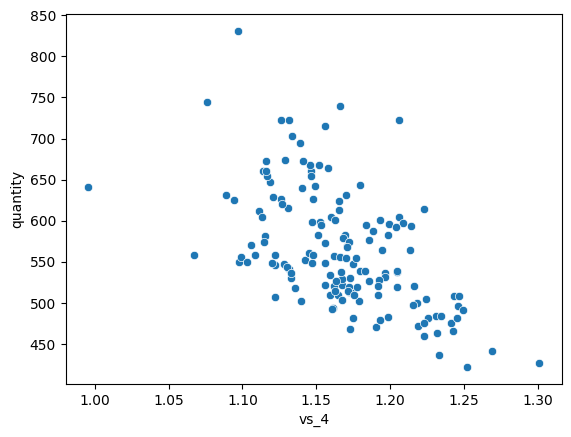

In [159]:
dfm['value_sales'] = dfm['quantity']*dfm['price']
dfg = dfm.groupby(by=['day', 'item_id']).agg({"quantity":'sum', 'value_sales':'sum'}).reset_index()
dfg['price'] = dfg['value_sales']/dfg['quantity']
ixsg = dfg.pivot(index=['day'], columns=['item_id'], values=['price'])
ixsg.columns = [f"vs_{i[1]}" for i in ixsg.columns.values]
ixsg = ixsg.reset_index()
dfg = dfg.merge(ixsg, on=['day'], how='left')
for c in [c for c in dfg.columns.values if "vs_" in c]:
    dfg.loc[:,c] = dfg['price']/dfg.loc[:,c] 

sns.scatterplot(data=dfg[dfg['item_id']==3], x='vs_4', y='quantity')

In [160]:
dfm['item_id'].drop_duplicates()

0         0
45000     1
90000     2
135000    3
180000    4
Name: item_id, dtype: object

/Users/kirill/Library/Python/3.11/lib/python/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<AxesSubplot: xlabel='price', ylabel='quantity'>

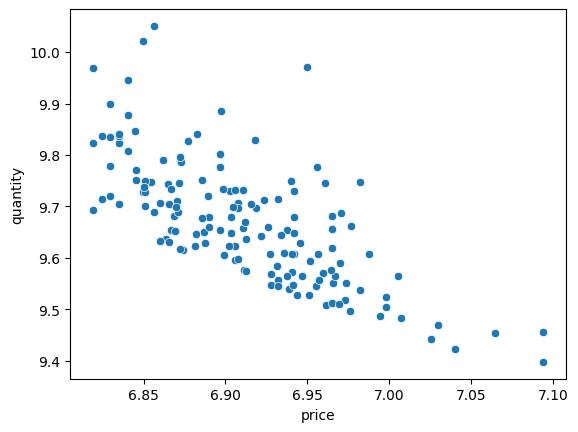

In [161]:
import seaborn as sns

dfm['value_sales'] = dfm['quantity']*dfm['price']
dfg = dfm.groupby(by=['day', 'item_id']).agg({"quantity":'sum', 'value_sales':'sum'}).reset_index()
dfg['price'] = dfg['value_sales']/dfg['quantity']
ixsg = dfg.pivot(index=['day'], columns=['item_id'], values=['price'])
ixsg.columns = [f"vs_{i[1]}" for i in ixsg.columns.values]
ixsg = ixsg.reset_index()
dfg = dfg.merge(ixsg, on=['day'], how='left')
for c in [c for c in dfg.columns.values if "vs_" in c]:
    dfg.loc[:,c] = dfg['price']/dfg.loc[:,c] 

sns.scatterplot(data=np.log(dfg[dfg['item_id']==0]), x='price', y='quantity')

In [163]:
formula = "np.log(quantity) ~ np.log(price):C(item_id) + "
for i in [c for c in dfm.columns.values if "vs_" in c]:
    formula += f"np.log({i}):C(item_id) + "
formula += " C(day) + C(store)"
y, X = patsy.dmatrices(formula, data=dfm, return_type='dataframe')
print(formula)

np.log(quantity) ~ np.log(price):C(item_id) + np.log(vs_0):C(item_id) + np.log(vs_1):C(item_id) + np.log(vs_2):C(item_id) + np.log(vs_3):C(item_id) + np.log(vs_4):C(item_id) +  C(day) + C(store)


In [164]:
model = glmnet.ElasticNet(alpha=0.2)
model.fit(X.values, y.values.ravel())

ElasticNet(alpha=0.2)

In [165]:
pd.DataFrame(price_elasticity_matrix)

,0,1,2,3,4
0,-1.2,0.0,0.0,0.0,0.0
1,0.0,-0.8,0.0,0.0,0.0
2,0.0,0.0,-1.6,-0.7,-0.6
3,-0.0,-0.3,0.0,-1.5,-0.5
4,0.0,0.0,0.0,-0.5,-1.6


In [166]:
res = pd.DataFrame({'name': X.columns.values, 'coef': model.coef_})
#res.to_excel('results.xlsx')
res[res['name'].str.contains('price')]

,name,coef
449,np.log(price):C(item_id)[0],0.083421
450,np.log(price):C(item_id)[1],0.552281
451,np.log(price):C(item_id)[2],-0.075648
452,np.log(price):C(item_id)[3],-0.177758
453,np.log(price):C(item_id)[4],-0.288262


In [167]:
model = smf.glm(formula=formula, data=dfm, family=sm.families.Gaussian())
result = model.fit(intercept=False)

In [168]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       np.log(quantity)   No. Observations:               225000
Model:                            GLM   Df Residuals:                   224526
Model Family:                Gaussian   Df Model:                          473
Link Function:               Identity   Scale:                        0.014547
Method:                          IRLS   Log-Likelihood:             1.5689e+05
Date:                Tue, 24 Oct 2023   Deviance:                       3266.2
Time:                        12:25:44   Pearson chi2:                 3.27e+03
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      11.3924      0.132     86.467      0.000      11.134      11.651
C(day)[T.1]                    -0.0176      0.005     -3.851      0.000      -0.027      -0.009
C(day)[T.2]                    -0.0570      0.005    -12.480      0.000      -0.066      -0.048
C(day)[T.3]                     0.0020      0.004      0.454      0.650      -0.007       0.011
C(day)[T.4]                     0.0276      0.004      6.150      0.000       0.019       0.036
C(day)[T.5]                     0.0969      0.004     21.549      0.000       0.088       0.106
C(day)[T.6]                     0.0174      0.005      3.833      0.000       0.009       0.026
C(day)[T.7]                     0.0542      0.004     12.067      0.000       0.045       0.063
C(day)[T.8]                    -0.0807      0.005    -17.689      0.000      -0.090      -0.072
C(day)[T.9]                    -0.0304      0.005     -6.615      0.000      -0.039      -0.021
C(day)[T.10]                   -0.1012      0.005    -22.409      0.000      -0.110      -0.092
C(day)[T.11]                   -0.0668      0.005    -14.800      0.000      -0.076      -0.058
C(day)[T.12]                    0.0438      0.005      9.567      0.000       0.035       0.053
C(day)[T.13]                    0.2698      0.004     60.364      0.000       0.261       0.279
C(day)[T.14]                   -0.0881      0.004    -19.621      0.000      -0.097      -0.079
C(day)[T.15]                   -0.0384      0.004     -8.550      0.000      -0.047      -0.030
C(day)[T.16]                    0.0606      0.005     13.411      0.000       0.052       0.069
C(day)[T.17]                   -0.0706      0.004    -15.798      0.000      -0.079      -0.062
C(day)[T.18]                   -0.0081      0.004     -1.810      0.070      -0.017       0.001
C(day)[T.19]                    0.0456      0.004     10.204      0.000       0.037       0.054
C(day)[T.20]                    0.0076      0.005      1.657      0.098      -0.001       0.017
C(day)[T.21]                   -0.0738      0.005    -16.345      0.000      -0.083      -0.065
C(day)[T.22]                   -0.0459      0.005    -10.134      0.000      -0.055      -0.037
C(day)[T.23]                    0.0660      0.004     14.763      0.000       0.057       0.075
C(day)[T.24]                   -0.0030      0.005     -0.655      0.513      -0.012       0.006
C(day)[T.25]                   -0.1009      0.004    -22.453      0.000      -0.110      -0.092
C(day)[T.26]                    0.0513      0.004     11.607      0.000       0.043       0.060
C(day)[T.27]                   -0.0963      0.004    -21.430      0.000      -0.105      -0.087
C(day)[T.28]                    0.0445      0.004      9.941      0.000       0.036       0.053
C(day)[T.29